# A Tutorial on Sparsity via Regularisation 

This file is created as a trial of sparsity on a regression example. We consider a dataset with p features and n sample. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or
$X \sim \mathcal{N}(\mu, \sigma^2)$.
The output is also generated based on a linear function including a noise term as follows 
\begin{align*}
Y&=X\beta+\epsilon \\
\epsilon &\sim \mathcal{N}(\mu, \sigma^2)
\end{align*}

In [612]:
import numpy as np
import matplotlib.pyplot as plt

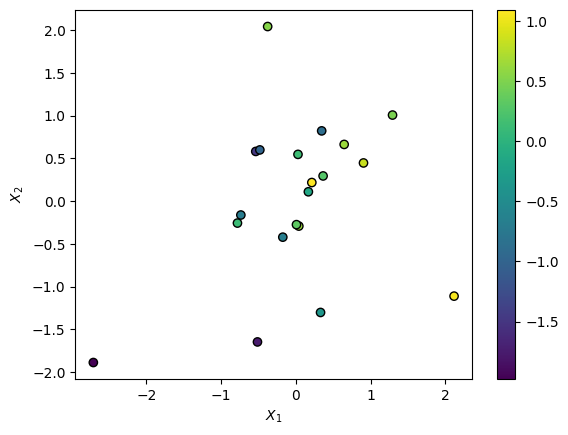

In [624]:
RNG = np.random.default_rng(seed=1)
p = 2
n = 20
var = 1
cov = var*np.eye(p)
mean = np.zeros(p)
sigma = 1

# To define the weights as beta
beta = np.array([1, 0]) 

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n)
y = x@beta + RNG.normal(0, sigma**2, size=n)

# To show the dataset
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.colorbar()
plt.show()

The loss function also is defined as a squared norm of residuals as 

\begin{equation*}
Loss\;Function=\vert\vert X\beta - Y\vert\vert_2^2
\end{equation*}

In [625]:
# To define the loss function
# def squared_error(beta):
#     return np.linalg.norm(x.dot(np.atleast_2d(beta).T) - y.reshape(-1, 1), axis=0)**2

# To define another form of loss function
def squared_error(beta):  ## Sum of abs residuals (norm 1)
    beta = np.reshape(beta,(-1, 2))
    return np.sum(abs(beta@x.T-y)**2,axis=1)

In [626]:
# To check the loss function
squared_error(beta)

array([10.26943722])

Then we define a space of 2 dimensions for all probable $\beta \subset \mathcal{R}^2$ and calculate the loss function for this space. After that the residuals (errors) corresponding to the all $\beta$
estimation space and real output would be calculated.

In [637]:
# To define the estimation space of beta
_beta1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[0]
_beta2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[1]
_beta = np.dstack((_beta1, _beta2))
_beta = np.reshape(_beta, (-1,2))

In [628]:
# To calculate the residuals between real output "y" and estimation space "x*_beta"
# error_space = squared_error(_beta)
# error_space

Now here we find the best estimated weights by least square optimization method.

In [629]:
# To define beta_hat by least square mathod
beta_hat = np.linalg.solve(x.T.dot(x), x.T.dot(y))
# least square in another calculation
# beta_hat = (np.linalg.inv(x.T@x)@x.T)@y
# beta_hat

Here we add a regularization (penalty/punishemnt) term to the loss function to sparse the solution space. It would be written as follows

\begin{equation*} 
Regularized\;Loss\;Function = \| X\beta - Y\|_2^2 + \alpha \|\beta \| 
\end{equation*}

The final goal is to obtain $\beta$ which minimize the regularized loss function. 

\begin{equation*} 
\hat{\beta} = \underset{\beta \in \mathcal{R}^2}{argmin} \; \| X\beta - Y\|_2^2 + \alpha\| \beta \|
\end{equation*}

Now we try to define the piecewise-penalty function as

\begin{equation*}
p(\beta) = \Bigg\{ 
    \begin{array}{rcl}
     |\beta| & if & \beta \le \frac{1}{2}\\
    |\beta-1 | & if & \beta > \frac{1}{2}\\
    \end{array} 
\end{equation*}

Text(0.5, 1.0, 'Piecewise-Penalty Function')

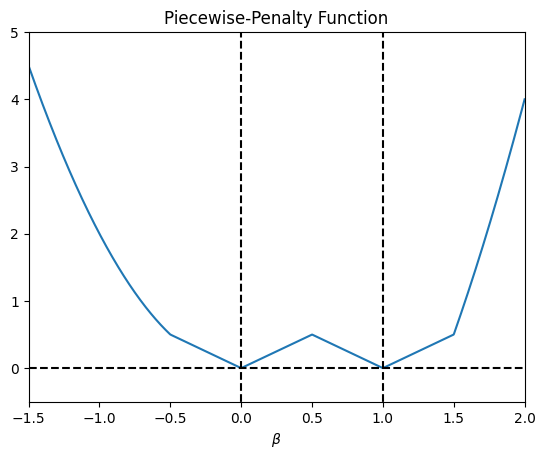

In [751]:
beta_range = np.linspace(-1.5, 2, 1000)
def penalty_function_order1(x):
    if x<=0.5:
      return abs(x)
    else:
      return abs(x-1)
fun = np.vectorize(penalty_function_order1)
penalty = fun(beta_range)

plt.plot(beta_range,penalty)
plt.vlines(0,-1,5,linestyles='--',colors='black')
plt.vlines(1,-1,5,linestyles='--',colors='black')
plt.hlines(0,-1.5,2,linestyles='--',colors='black')
plt.ylim([-0.5,5])
plt.xlim([-1.5,2])
plt.xlabel('$\\beta$')
plt.title('Piecewise-Penalty Function')
plt.title('Piecewise-Penalty Function')

In [630]:
from numpy.linalg import norm

# alpha=100
# def regularised_error(beta):
#     return squared_error(beta) + alpha*norm(np.atleast_2d(beta), 1, axis=1)

# To define the regularized loss function
def regularised_error(beta,alpha):
    return squared_error(beta) + alpha*np.sum(abs(np.reshape(beta,(-1,2))),axis=1)


In [732]:
# To define the regularized loss function with piecewise penalty term
# def sparsed_regularised_error(beta,alpha):
#     r = np.where(abs(beta)<=1, abs(beta), 0.5*beta**2+0.5)
#     return squared_error(beta) + alpha*np.sum(r)

# def sparsed_regularised_error(beta,alpha):
#     # p1 = np.where(abs(beta)<=0.5, abs(beta), beta**2+0.5)
#     # p2 = np.where(0.5<=any(beta)<=1.5, abs(beta-1), beta**2-1.75)
#     p = []
#     for b in beta:
#         if b<-0.5:
#             p.append(2*b**2)
#         elif abs(b)<=0.5:
#             p.append(abs(b))
#         elif b>=0.5 and b<=1.5:
#             p.append(abs(b-1))
#         else:
#             p.append(2*b**2-4)
#     return squared_error(beta) + alpha*np.sum(p)


def sparsed_regularised_error(beta,alpha):
  pp = []
  beta = np.reshape(beta,(-1, 2))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(abs(b))
      else:
        p.append(abs(b-1))
    pp.append(alpha*np.sum(p))
  return squared_error(beta)+np.asarray(pp)

In [733]:
import scipy
from scipy.optimize import minimize
alpha=1
def minimizer(error_function, alpha):
    initial_beta = np.random.randint(p,size=(2))
    # initial_beta = np.array([0,0])
    # scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')
    result = minimize(error_function, initial_beta, method='Powell', args=(alpha), tol=1e-8)
    optimized_beta = result.x
    return optimized_beta
# scipy.optimize.show_options(solver='minimize', method='Nelder-Mead')

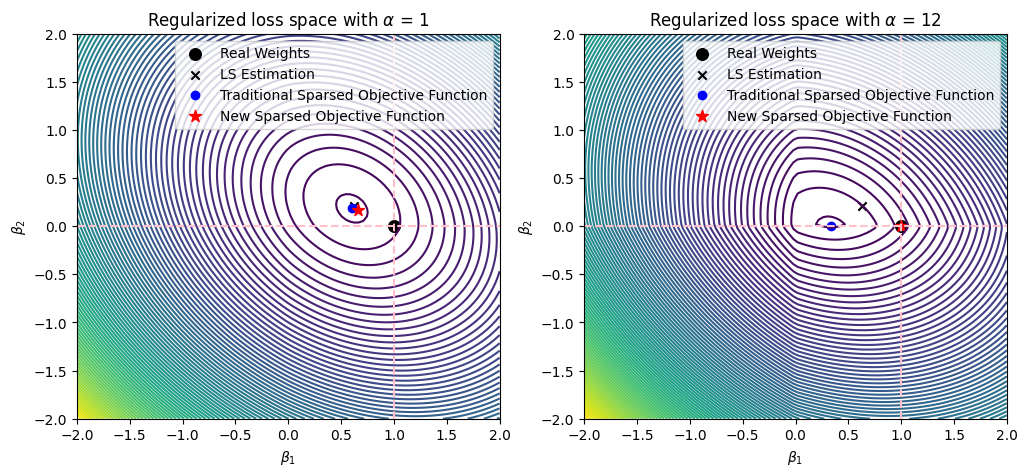

In [735]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(3, 2, figsize=(12, 15))

a = 1
axs[0,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[0,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[0,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[0,0].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[0,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[0,0].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='blue', label='Traditional Sparsed Objective Function')
# axs[0,0].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[0,0].set_xlabel('$\\beta_1$')
axs[0,0].set_ylabel('$\\beta_2$')
axs[0,0].legend()
axs[0,0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[0,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), sparsed_regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[0,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[0,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[0,1].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[0,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
# axs[0,1].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='blue', label='Traditional Sparsed Objective Function')
axs[0,1].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[0,1].set_xlabel('$\\beta_1$')
axs[0,1].set_ylabel('$\\beta_2$')
axs[0,1].legend()
axs[0,1].title.set_text('Regularized loss space with $\\alpha$ = ' + str(a))


a = 3
axs[1,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[1,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[1,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[1,0].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[1,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[1,0].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='blue', label='Traditional Sparsed Objective Function')
# axs[1,0].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[1,0].set_xlabel('$\\beta_1$')
axs[1,0].set_ylabel('$\\beta_2$')
axs[1,0].legend()
axs[1,0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[1,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), sparsed_regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[1,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[1,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[1,1].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[1,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
# axs[1,1].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='blue', label='Traditional Sparsed Objective Function')
axs[1,1].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[1,1].set_xlabel('$\\beta_1$')
axs[1,1].set_ylabel('$\\beta_2$')
axs[1,1].legend()
axs[1,1].title.set_text('Regularized loss space with $\\alpha$ = ' + str(a))

a = 10
axs[2,0].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[2,0].vlines(1,-2,2,linestyles='--',colors='pink')
axs[2,0].hlines(0,-2,2,linestyles='--',colors='pink')
axs[2,0].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[2,0].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
axs[2,0].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='blue', label='Traditional Sparsed Objective Function')
# axs[2,0].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[2,0].set_xlabel('$\\beta_1$')
axs[2,0].set_ylabel('$\\beta_2$')
axs[2,0].legend()
axs[2,0].title.set_text('Regularized loss space with $\\alpha$ = '+ str(a))

axs[2,1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), sparsed_regularised_error(_beta,alpha=a).reshape(100, 100), levels=100)
axs[2,1].vlines(1,-2,2,linestyles='--',colors='pink')
axs[2,1].hlines(0,-2,2,linestyles='--',colors='pink')
axs[2,1].scatter(beta[0], beta[1], marker='o', color='black', label='Real Weights', s=70)
axs[2,1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black', label='LS Estimation')
# axs[2,1].scatter(minimizer(regularised_error,alpha=a)[0], minimizer(regularised_error,alpha=a)[1], marker='o', color='blue', label='Traditional Sparsed Objective Function')
axs[2,1].scatter(minimizer(sparsed_regularised_error,alpha=a)[0], minimizer(sparsed_regularised_error,alpha=a)[1], marker='*', color='red', s=80, label='New Sparsed Objective Function')
axs[2,1].set_xlabel('$\\beta_1$')
axs[2,1].set_ylabel('$\\beta_2$')
axs[2,1].legend()
axs[2,1].title.set_text('Regularized loss space with $\\alpha$ = ' + str(a))



plt.show()

In [ ]:
piecewise = []
traditional = []

for a in range(20):
    a = a + 1
    piecewise.append(minimizer(sparsed_regularised_error,alpha=a))
    traditional.append(minimizer(regularised_error,alpha=a))
piecewise_penalty = np.asarray(piecewise)
traditional_penalty = np.asarray(traditional)

(-0.2, 0.8)

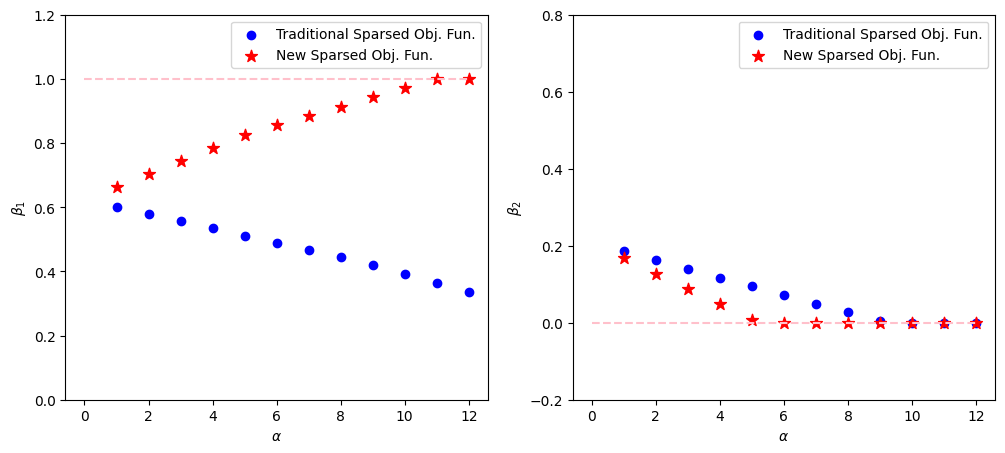

In [736]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 5))

alpha_range = np.asarray(range(20))+1

axs[0].hlines(1,0,12,linestyles='--',colors='pink')
axs[0].scatter(alpha_range, traditional_penalty[:,0], marker='o', color='blue', label='Traditional Sparsed Obj. Fun.')
axs[0].scatter(alpha_range, piecewise_penalty[:,0], marker='*', color='red', s=80, label='New Sparsed Obj. Fun.')
axs[0].set_xlabel('$\\alpha$')
axs[0].set_ylabel('$\\beta_1$')
axs[0].legend()
axs[0].set_ylim([0, 1.2])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')

axs[1].hlines(0,0,12,linestyles='--',colors='pink')
axs[1].scatter(alpha_range, traditional_penalty[:,1], marker='o', color='blue', label='Traditional Sparsed Obj. Fun.')
axs[1].scatter(alpha_range, piecewise_penalty[:,1], marker='*', color='red', s=80, label='New Sparsed Obj. Fun.')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('$\\beta_2$')
axs[1].legend()
axs[1].set_ylim([-0.2, 0.8])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')

Lets to define the piecewise-penalty function as

\begin{equation*}
p(\beta) = \Bigg\{ 
\begin{array}{rcl}
|\beta| & if & |\beta| \le \frac{1}{2}\\
|\beta-1 |& if & \frac{1}{2} < \beta \le \frac{3}{2}\\
(\beta-\frac{1}{2})ˆ2-\frac{1}{2} & if & otherwise\\
\end{array} 
\end{equation*}

In [ ]:
beta_range = np.linspace(-1, 2, 1000)
def penalty_function_order2(x):
    if abs(x)<=0.5:
      return abs(x)
    elif x>0.5 and x<=1.5:
      return abs(x-1)
    # elif x<-0.5:
    #   return 2*(x-0.5)**2-1.5
    else:
      return (x-0.5)**2-0.5
fun = np.vectorize(penalty_function_order2)
penalty = fun(beta_range)

plt.plot(beta_range,penalty)
plt.vlines(0,-1,5,linestyles='--',colors='black')
plt.vlines(1,-1,5,linestyles='--',colors='black')
plt.hlines(0,-1.5,2,linestyles='--',colors='black')
plt.ylim([-0.5,2])
plt.xlim([-1,2])
plt.xlabel('$\\beta$')
plt.title('Piecewise-Penalty Function')

In [ ]:
def sparsed_regularised_error(beta,alpha):
  pp = []
  beta = np.reshape(beta,(-1, 2))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if abs(b)<=0.5:
        p.append(abs(b))
      elif b>0.5 and b<=1.5:
        p.append(abs(b-1))
      else:
        p.append(2*(b-0.5)**2-1.5)
    pp.append(alpha*np.sum(p))
  return squared_error(beta)+np.asarray(pp)

In [ ]:
piecewise = []
traditional = []

for a in range(20):
    a = a + 1
    piecewise.append(minimizer(sparsed_regularised_error,alpha=a))
    traditional.append(minimizer(regularised_error,alpha=a))
piecewise_penalty = np.asarray(piecewise)
traditional_penalty = np.asarray(traditional)


In [ ]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(12, 5))

alpha_range = np.asarray(range(20))+1

axs[0].hlines(1,0,12,linestyles='--',colors='pink')
axs[0].scatter(alpha_range, traditional_penalty[:,0], marker='o', color='blue', label='Traditional Sparsed Obj. Fun.')
axs[0].scatter(alpha_range, piecewise_penalty[:,0], marker='*', color='red', s=80, label='New Sparsed Obj. Fun.')
axs[0].set_xlabel('$\\alpha$')
axs[0].set_ylabel('$\\beta_1$')
axs[0].legend()
axs[0].set_ylim([0, 1.2])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')

axs[1].hlines(0,0,12,linestyles='--',colors='pink')
axs[1].scatter(alpha_range, traditional_penalty[:,1], marker='o', color='blue', label='Traditional Sparsed Obj. Fun.')
axs[1].scatter(alpha_range, piecewise_penalty[:,1], marker='*', color='red', s=80, label='New Sparsed Obj. Fun.')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('$\\beta_2$')
axs[1].legend()
axs[1].set_ylim([-0.2, 0.8])
# axs[0].title.set_text('$\\beta_1$ vs $\\alpha$')